"""  #    
# Trabajo final de Aprendizaje No Supervisado
- **Coordinador**: Adrien Felipe
- **Secretaria**: Carolina Martínez
- **Revisor**: Enrique Navarro

"""  #

# Datasets
## Preparación
### Librerías

In [42]:
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Para las medidas y algoritmos.
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, MeanShift, SpectralClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, cut_tree

# Eliminamos avisos molestos
import warnings

warnings.filterwarnings("ignore")

"""  #    
### Funciones de apoyo
#### Función de carga del dataset
Preparamos una función genérica para para simplificar la descarga de los datasets y su preparación.     
Ésta nos permite escoger los atributos que usaremos, así como extraer a una variable las clases reales del dataset en caso de estar disponibles.    

Descripción de sus parámetros:
 - dataset_url: cadena con la ruta al recurso desde donde cargar el dataset.
 - attributes: atributos del dataset a usar (pocisión y nombre).
 - separator (opcional): caracter de división en el origen del dataset.
 - class_position (opcional): ubicación en el dataset de la clase.

"""  #


In [43]:
def load_dataset(dataset_url: str, attributes: dict, separator: str = '\s+', class_position: int = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from a text based dataset
    :param dict attributes: attributes to keep in dictionary form:
        key: attribute position, value: attribute name
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
        if left empty (None), no prediction class will be used (intrinsic case).
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Add class index to the indexes to extract.
    if class_position is not None:
        attributes[class_position] = 'classes'

    # Keep only desired attributes and classes.
    dataset = dataset[attributes]

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Do not transform classes.
        if column == class_position:
            continue

        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    dataset.dropna(inplace=True)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset[class_position]
        # Remove classes from attributes.
        dataset.drop(class_position, axis=1, inplace=True)

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    # Set attributes title.
    dataset.rename(columns=attributes, inplace=True)

    return classes, dataset


"""  #    
#### Función de visualización
Usaremos una función común para presentar los datos, tanto si están clasificados como si no.       
Esta función presenta una combinación de dos en dos de todos los atributos, asi como adapta las dimensiones de la
gráfica según la cantidad de sub-gráficas a presentar.

Recibe dos parámetros:
 - dataset: El DataFrame con los atributos a representar
 - classes (opcional): El DataFrame con la clase de cada instancia

"""  #


In [44]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    # Combine all attributes two by two.
    combinations = list(it.combinations(dataset.columns, r=2))
    # Limit the number of plot columns.
    max_cols = 4
    cols = len(combinations) if len(combinations) <= max_cols else max_cols
    # From the columns number, set rows number.
    rows = int(np.ceil(len(combinations) / cols))

    # Calculate plot sizes depending on subplots number.
    size_x = int(13 * cols / max_cols) + 7
    size_y = 6 if rows * cols == 1 else 5 * rows

    # Build up all subplot combinations.
    fig, ax = plt.subplots(rows, cols, figsize=(size_x, size_y))
    for key, pair in enumerate(combinations):
        # Calculate plot axis position from sub-plot key.
        column = key % cols
        row = int(key / cols) % rows
        # Position needs to be a list when multiple rows.
        position = column if rows == 1 else (row, column)
        # Ax is not an array when single row and column.
        subplot = ax if rows * cols == 1 else ax[position]

        # Plot attributes values and titles.
        subplot.scatter(dataset[pair[0]], dataset[pair[1]], c=classes)
        subplot.set_title(str(pair[0]) + ' / ' + str(pair[1]))


"""  #    
### Funciones propias de cálculo de medidas extrínsecas:

"""  #


In [45]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real == cats[i], cat_pred == clusts[j]))
                     for j in np.arange(clusts.size)]
                    for i in np.arange(cats.size)])
    return (mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l, :]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))


def medida_precision(mat, l, k):
    return mat[l, k] / sum(mat[:, k])


def medida_recall(mat, l, k):
    return mat[l, k] / sum(mat[l, :])


def medida_pureza(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    return np.sum([
        totales[k] * np.max(mat[:, k] / float(np.sum(mat[:, k])))
        for k in np.arange(mat.shape[1])
    ])

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec + rec) == 0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)


def medida_f1(mat):
    totales = np.sum(mat, axis=1) / float(np.sum(mat))
    assign = np.sum([
        totales[l] * np.max([
            medida_f1_especifica(mat, l, k)
            for k in np.arange(mat.shape[1])
        ])
        for l in np.arange(mat.shape[0])
    ])
    return assign

def medida_entropia(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    relMat = mat / np.sum(mat, axis=0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat == 0] = 0.0001  # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([
        totales[k] * np.sum([
            relMat[l, k] * logRelMat[l, k]
            for l in np.arange(mat.shape[0])
        ])
        for k in np.arange(mat.shape[1])
    ])

"""  #     
#### Función de cálculo de las medidas extrínsecas
Con la intensión de simplificar y unificar la captura de las métricas de valoración aplicadas a cada algoritmo, preparamos una función que calcula varias medidas cualitativas del agrupamiento, de forma a poder compararlas.    

Ésta aplica las siguiente métricas:
 - Error, pureza, entropía, información mutua y F1 tal como se han visto en clase.
 - ARI mide la similaridad entre las clases y los predichos
 - Homogeneidad (todos los valores predichos son del clúster correcto)
 - Completación (todos los valores de una clase se predicen en el mismo clúster)
 - Medida V (media armónica de homogeneidad y completación). Parámetro beta (por defecto 1) para ponderar
 - Fowlkes-Mallows es la media geométrica de las parejas precision-recall
 - Silhouette
 - Calinski-Harabasz
 - Davies-Bouldin

 Para simplificar la comparación de resultados, se crea una media de algunos de los parámetros, que son compatibles por
 puntuar con un máximo de 1. Nos basaremos en ella para considerar qué algoritmo ofrece mejor resultado.

"""  #


In [46]:
def calculate_extrinsic_metrics(dataset, real_classes, predicted_classes):
    confusion_matrix = matriz_confusion(real_classes, predicted_classes)

    return {
        'Error': medida_error(confusion_matrix),
        'Pureza': medida_pureza(confusion_matrix),
        'F1': medida_f1(confusion_matrix),
        'Entropía': medida_entropia(confusion_matrix),
        'Información mútua': metrics.mutual_info_score(real_classes, predicted_classes),
        'ARI': metrics.adjusted_rand_score(real_classes, predicted_classes),
        'Homogeneidad': metrics.homogeneity_score(real_classes, predicted_classes),
        'Completación': metrics.completeness_score(real_classes, predicted_classes),
        'Medida V': metrics.v_measure_score(real_classes, predicted_classes),
        'Fowlkes-Mallows': metrics.fowlkes_mallows_score(real_classes, predicted_classes),
        'Silhouette': metrics.silhouette_score(dataset, predicted_classes, metric='euclidean'),
        'Calinski-Harabasz': metrics.calinski_harabasz_score(dataset, predicted_classes),
        'Davies-Bouldin': davies_bouldin_score(dataset, predicted_classes),
        'media': (medida_pureza(confusion_matrix)+medida_f1(confusion_matrix)+metrics.mutual_info_score(real_classes, predicted_classes)+metrics.adjusted_rand_score(real_classes, predicted_classes)+metrics.homogeneity_score(real_classes, predicted_classes)+metrics.completeness_score(real_classes, predicted_classes)+metrics.v_measure_score(real_classes, predicted_classes)+metrics.fowlkes_mallows_score(real_classes, predicted_classes))/8
    }

"""  #    
### Funciones de cálculo de medidas intrínsecas
En el caso de la evalución cualitativa del agrupamiento de los algoritmos intrínsecas, usaremos exclusivamente métricas disponibles en sklearn:
 - Silhouette
 - Calinski-Harabasz
 - Davies-Boudin

Debido a que RMSSTD, R² y la Medida I requieren de centroides, que no todos los algoritmos utilizan, decidimos prescindir de ellas.

"""  #


In [47]:
def calculate_intrinsic_metrics(dataset, prediction):
    return {
        'Silhouette': metrics.silhouette_score(dataset, prediction),
        'Calinski Harabasz': metrics.calinski_harabasz_score(dataset, prediction),
        'Davies Bouldin': metrics.davies_bouldin_score(dataset, prediction)
    }

def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R² score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator

""" #    
### Función para presentar las métricas

Finalmente se crea una función que simplifique la comparación de métricas entre distintos algoritmos.

"""  #


In [48]:
def compare_metrics(metrics_data: dict) -> pd.DataFrame:
    output = pd.DataFrame(metrics_data)
    return output

""" #    
Función para generar gráficamente la evolución de las métricas R² y Silueta según el número de clusters, para poder escoger el número de clusters óptimo usando la técnica del codo.

"""  #

In [49]:
def plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")

## Selección

"""  #    
### Dataset extrínseca
El origen de este dataset se remonta a datos usados en 1983 por la <i>American Statistical Association Exposition</i> y que se conservan en la Universidad de Carnegie Mellon, al que le faltan 8 instancias que se eliminaron para homogeneizar el dataset, ya que carecían del campo mpg.

 El dataset consta de:
 - 392 instancias
 - 8 atributos:    
     - mpg (millas por galón de combustible): de tipo continuo.    
     - cylinders (cilindros): discreto multi evaluado.    
     - displacement (cilindrada): continuo.    
     - horsepower (caballos de potencia): continuo.    
     - weight (peso): continuo    
     - acceleration (aceleración): continuo    
     - model-year (año del modelo): discrto multi evaluado.    
     - origin (origen): discreto multi evaluado.    
     - car name (nombre del coche): cadena (único para cada instancia)    

Para el estudio que nos ocupa vamos a predecir el número de cilindros basándonos en el consumo, la cilindrada y la potencia.

"""  #

In [50]:
# Cargamos el dataset.
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
attributes = {0: 'mpg', 2: 'cilindrada', 3: 'potencia'}
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, attributes, class_position=1)

# Soporte para las métricas
extrinsic_metrics = {}

"""  #    
Se descartan el resto de valores para mantener baja la dimensión del vector descriptor y simplificar así los cálculos.
Los datos vienen casi listos para trabajar con ellos. No se detectan campos vacíos:

"""  #

In [51]:
print(extrinsic_dataset.isnull().any())

mpg           False
cilindrada    False
potencia      False
dtype: bool


""" #    
Sin embargo, en la potencia existe un valor anómalo, un "?" usado donde se desconocía el dato, por lo que se ha incorporado a la función de carga de datos un filtro para eliminarlo.

Vamos a observar la distribución de nuestra clase:

"""  #

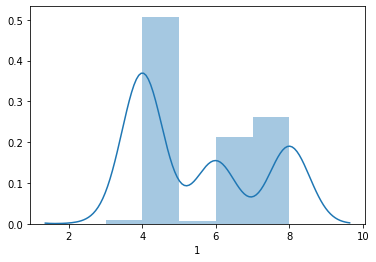

In [52]:
sns.distplot(extrinsic_classes)

""" #    
Se observa una marcada preponderancia de los valores de cilindros 4,6 y 8. Asumimos que probablemente las instancias que no pertenezcan a estos tres grupos se agrupen dentro de ellos lo que va a conllevar un pequeño error de base al escoger agrupamientos.

Y la relación entre los atributos:


"""  #

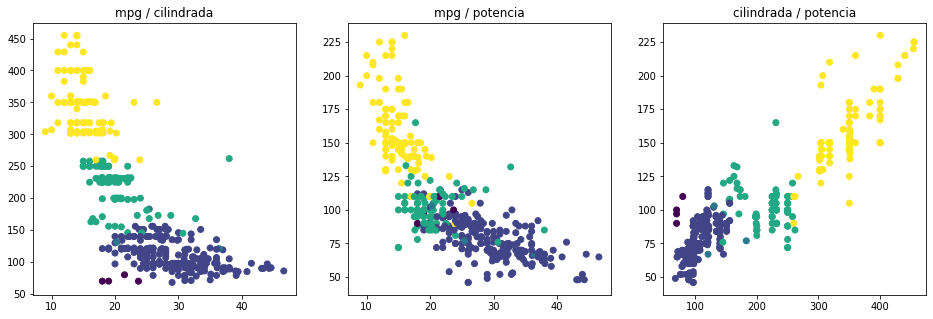

In [53]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

""" #    
# Análisis dataset extrínseca

Observando los datos es evidente que el número óptimo de clústers para K-means es 3.
     
Definimos un variable con el número de cluster que usaremos para el análisis:
"""  #

In [ ]:
extrinsic_clusters = 3

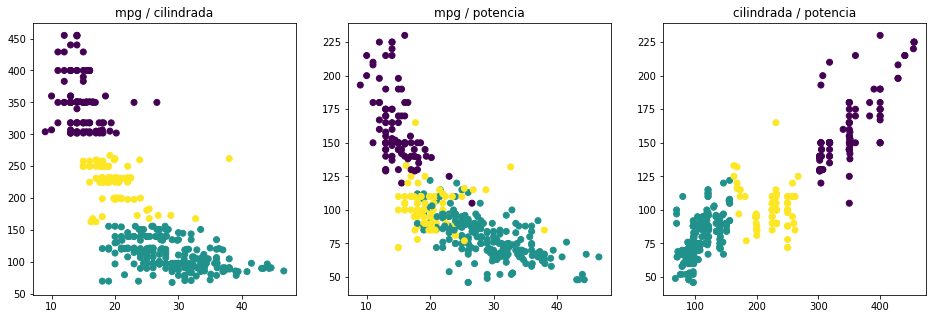

In [54]:
## Algoritmos

### Algoritmo 1: K medias


# Generamos el modelo.
model = KMeans(n_clusters=extrinsic_clusters).fit(extrinsic_dataset)
prediction = model.predict(extrinsic_dataset)

# Guardamos la métricas.
extrinsic_metrics['k-means'] = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### ### Algoritmo 2: jerárquico aglomerativo

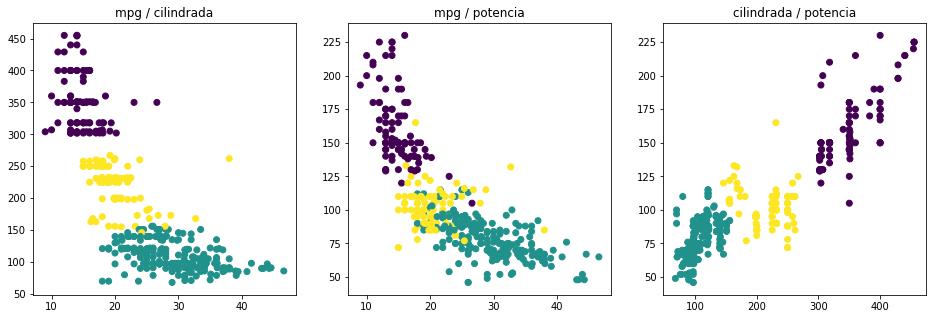

In [55]:
# Generamos el modelo.
model = linkage(extrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=extrinsic_clusters).flatten()
# Guardamos la métricas.
extrinsic_metrics['Jerárquico'] = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)


### Algoritmo 3: DBSCAN

Mejor distancia identificada: 24.5


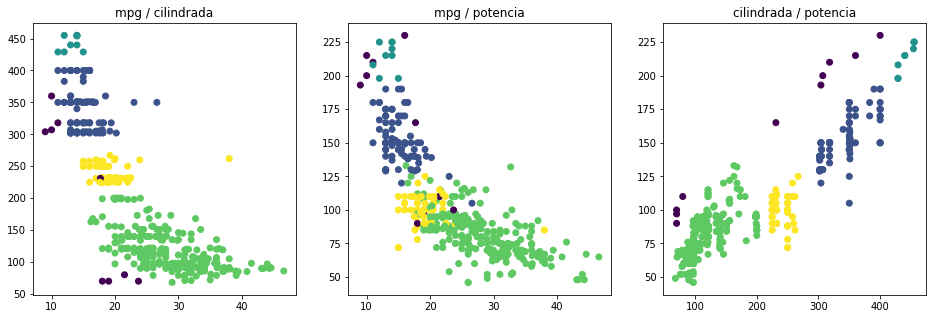

In [56]:
def calcular_DBSCAN(eps):
    modelo = DBSCAN(eps=eps).fit(extrinsic_dataset)
    labels_pred = modelo.labels_
    x = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, labels_pred)
    media = (x['ARI'] + x['Información mútua'] + x['Homogeneidad'] + x['Completación'] + x['Medida V'] + x[
        'Fowlkes-Mallows']) / 6
    return {"modelo": modelo, "mediciones": x, 'media': media, "prediction": labels_pred}


def repetir_dbscan(r):
    r *= 2
    res = {"media": 0}
    for i in np.arange(20 * 2, r + 1):
        x = calcular_DBSCAN(i / 2)
        if x["media"] > res["media"]:
            res = x
            res["distancia"] = i / 2
    return res


eps = 30  # Distancia máxima a probar (en pasos de 0.5)
best = repetir_dbscan(eps)
print("Mejor distancia identificada:", best["distancia"])
extrinsic_metrics["DBSCAN"] = best["mediciones"]

plot_dataset(extrinsic_dataset, best["prediction"])

### Algoritmo 4: Deslizamiento de media

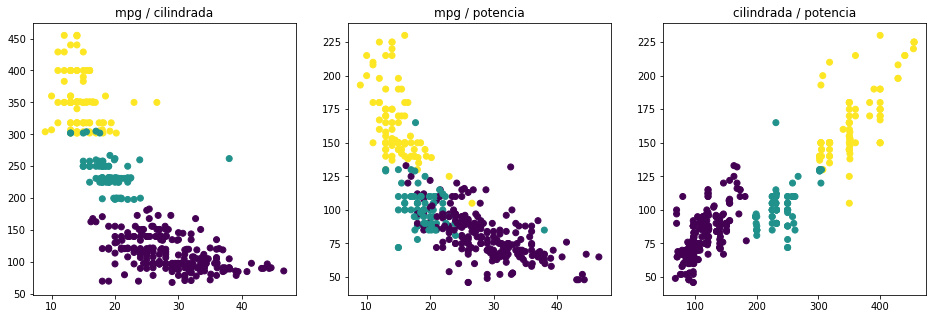

In [57]:
# Generamos el modelo.
model = MeanShift().fit(extrinsic_dataset)
prediction = model.labels_

# Guardamos la métricas.
extrinsic_metrics['Means-Shift'] = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)


### Algritmo 5: Espectral

Buscando mejor clustering espectral.
Probando de 1 a 30 vecinos más cercanos y repitiendo 10 veces.
Tiempo de ejecución estimado: 16 segundos.
El mejor espectral encontrado es con 10 vecinos y da una media de 0.6041735486031022


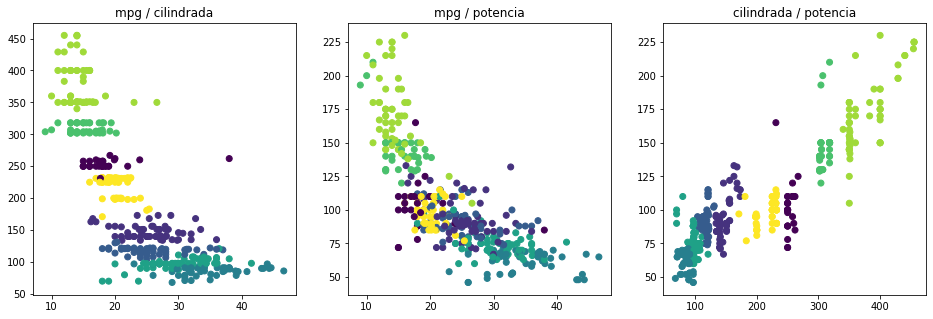

In [58]:
def mejor_espectral(nn):
    vecinos = 0
    media_max = 0
    modelo_fin = None
    for i in np.arange(nn):
        modelo = SpectralClustering(affinity='nearest_neighbors', n_neighbors=i + 1).fit(extrinsic_dataset)
        labels_pred = modelo.labels_
        x = calculate_extrinsic_metrics(extrinsic_dataset, extrinsic_classes, labels_pred)
        x['media'] = (x['ARI'] + x['Información mútua'] + x['Homogeneidad'] + x['Completación'] + x['Medida V'] + x[
            'Fowlkes-Mallows']) / 6
        if x["media"] > media_max:
            vecinos = i + 1
            media_max = x["media"]
            modelo_fin = modelo
    return {"modelo": modelo_fin, "vecinos": vecinos, "mediciones": x, "prediction": labels_pred}


def repetir_espectral(v, r):
    print("Buscando mejor clustering espectral.\nProbando de 1 a", v, "vecinos más cercanos y repitiendo", r,
          "veces.\nTiempo de ejecución estimado:", int((v / 53) * 3 * r), "segundos.")
    mejor = {"mediciones": {"media": 0}}
    for i in np.arange(r + 1):
        res = mejor_espectral(v)
        if res["mediciones"]["media"] > mejor["mediciones"]["media"]:
            mejor = res
    return mejor


vecinos = 30
repeticiones = 10
best = repetir_espectral(vecinos, repeticiones)
print("El mejor espectral encontrado es con", best["vecinos"], "vecinos y da una media de", best["mediciones"]["media"])
# for key, value in best["mediciones"].items():
#     print(key, ":", value)
extrinsic_metrics["Espectral"] = best["mediciones"]

plot_dataset(extrinsic_dataset, best["prediction"])

## Comparación algoritmos

"""  #    
Vamos pues a obtener una comparativa de los algoritmos para nuestro dataset extrínseco:
"""  #

In [59]:
display(compare_metrics(extrinsic_metrics))

,k-means,Jerárquico,DBSCAN,Means-Shift,Espectral
Error,0.030612,0.025510,0.122449,0.068878,0.581633
Pureza,0.954082,0.959184,0.895408,0.913265,0.933673
F1,0.946000,0.951288,0.874093,0.904644,0.559100
Entropía,0.210296,0.194421,0.324870,0.317746,0.189480
Información mútua,0.897830,0.913705,0.783256,0.790380,0.918645
ARI,0.893676,0.908206,0.730511,0.794505,0.328645
Homogeneidad,0.810224,0.824550,0.706830,0.713258,0.829008
Completación,0.890105,0.893861,0.706785,0.803680,0.446287
Medida V,0.848288,0.857808,0.706807,0.755774,0.580219
Fowlkes-Mallows,0.934849,0.943101,0.836886,0.876179,0.522237


"""  #    
Por lo que se observa, basándonos en la media calculada, que el <b>mejor algoritmo para el agrupamiento de nuestros datos es el de agrupamiento jerárquico, prácticamente igualado a K Medias</b>, seguidos por desplazamiento de medias y DBSCAN.

El espectral, en cambio, no resulta muy apropiado para este caso.
"""  #

"""  #    
### Dataset intrínseca
El dataset intrínseca **Aggregations** está generado de manera artificial por: *A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007*


Este dataset está compuesto por 788 observaciones de 2 variables que abarcan un amplio rango numérico. En el conjunto de datos existen entre 5 a 7 grupos que se distribuyen en zonas particulares del rango de valores de las variables.


Cargamos nuestro dataset (*intrinsic_dataset*):

"""  #

In [60]:
# Cargamos el dataset.
dataset_url = 'http://cs.joensuu.fi/sipu/datasets/Aggregation.txt'
attributes = {0: 'dim 1', 1: 'dim 2'}
_, intrinsic_dataset = load_dataset(dataset_url, attributes)

# Soporte para las métricas
intrinsic_metrics = {}

"""  #    
Visualizamos el dataset en 2-D:

"""  #

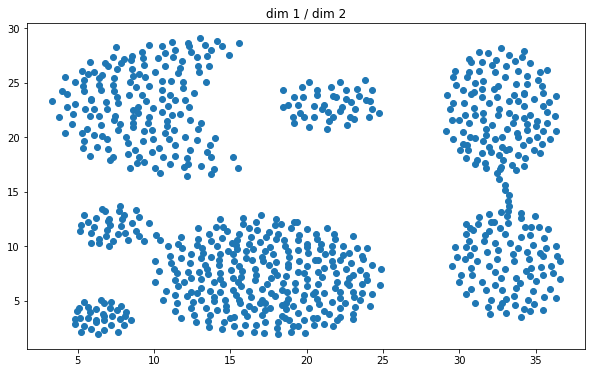

In [61]:
plot_dataset(intrinsic_dataset)

"""  #    
Observando las características de esta representación, podemos decir que es un conjunto de datos compacto, 
lo que nos permitirá obtener resultados aceptables con con algoritmos de agrupamiento K-means y jerárquicos, 
y parece que se podría clasificar con 4, 5 o con 7 clusters.

"""  #

# Análisis dataset intrínseca
## Algoritmos

"""  #    
### Algoritmo 1: K medias
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

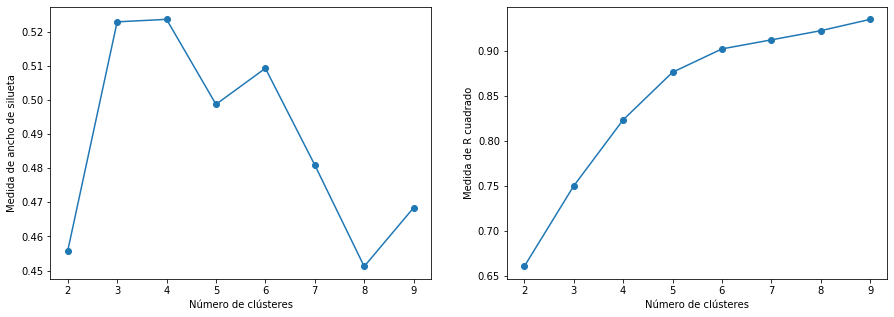

In [62]:
plot_clusters_selection(intrinsic_dataset)

"""  #    
Según el procedimiento del codo, escogeríamos entre 5 y 7 clusters. Aunque estos valores son para escoger la cantidad óptima de centroides, son los valores sobre los que hemos realizado el análisis de todos los algoritmos utilizados.

Usamos un variable con el número buscado de clusters:

"""  #

In [63]:
intrinsic_clusters = 7

"""  #
#### Ejecución del algoritmo
Durante el análisis ejecutamos la predicción de k-means con 5, 6 y 7 clusters, y finalmente ejecutamos y visualizamos la agrupación generada para K = 7.

"""  #

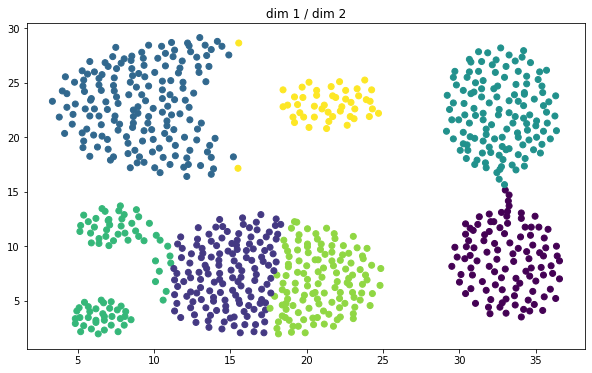

In [64]:
# Generamos el modelo.
model = KMeans(n_clusters=intrinsic_clusters).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)

# Guardamos la métricas.
intrinsic_metrics['k-means'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

"""  #    
Vemos que buena parte de los grupos se han identificado correctamente, o con mínimas interferencias (el grupo amarillo \"invade\" al azul oscuro en dos puntos). Sin embargo, los dos grupos pequeños de abajo a la izquierda los considera uno, junto con algunos puntos del grupo grande a su lado, que a su vez está dividido en dos.

"""  #

### Algoritmo Jerárquico Aglomerativo

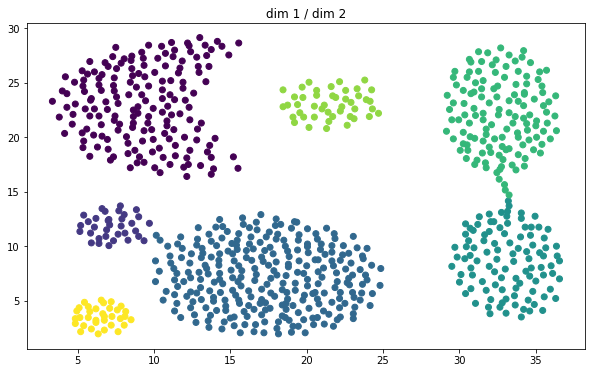

In [67]:
# Generamos el modelo.
model = linkage(intrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=intrinsic_clusters).flatten()

# Guardamos la métricas.
intrinsic_metrics['Jerárquico'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

El resultado de este algoritmo de agrupamiento es excelente, acertando completamente los 7 grupos que se adivinan visualmente.AQUI TENDREMOS QUE COMENTAR ALGO

### Algoritmo Agrupamiento espectral

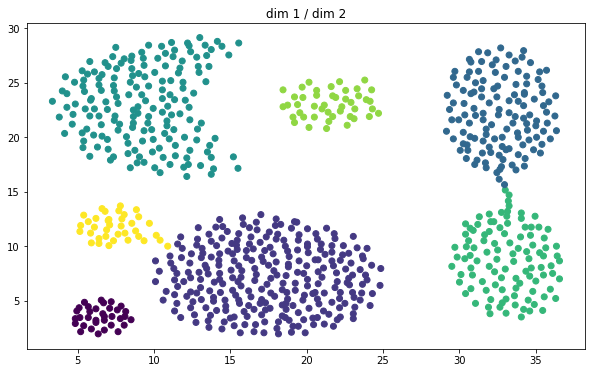

In [68]:
# Generamos el modelo.
knn = 34
model = SpectralClustering(
    n_clusters=intrinsic_clusters, affinity='nearest_neighbors', n_neighbors=knn, random_state=0
).fit(intrinsic_dataset)
prediction = model.labels_

# Guardamos la métricas.
intrinsic_metrics['Espectral'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

"""  #    
El jerárquico con 30 KNN resuelve bien la clusterización con 7 grupos, si se reduce no lo hace tan bien, y  partir de 50 tampoco. Hay que encontar el valor correcto.    
Buscando 5 clusters también lo hace bien.

"""  #

### Algoritmo Mean Shift

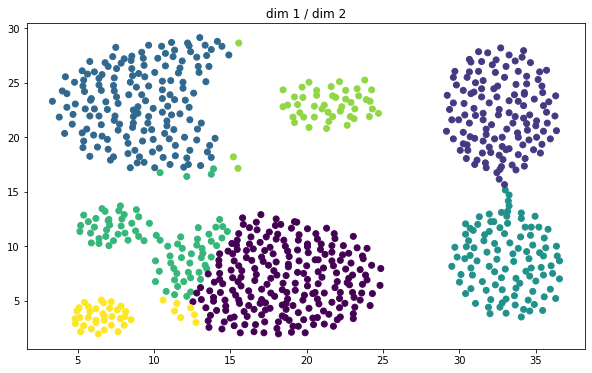

In [69]:
# Generamos el modelo.
h = 4
model = MeanShift(bandwidth=h).fit(intrinsic_dataset)
prediction = model.labels_

# Guardamos la métricas.
intrinsic_metrics['Means-Shift'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

Este algoritmo resuelve casi correctamente el agrupamiento, identificando los 7 grupos pero asignando mal algunos puntos, incluyendo en los grupos pequeños puntos de los grupos grandes más cercanos. Es un problema conocido del algoritmo, al trabajar sobre una media general para todos los agrupamientos.AQUI TAMBIÉN TENDREMOS QUE COMENTAR ALGO

### Algoritmo EM

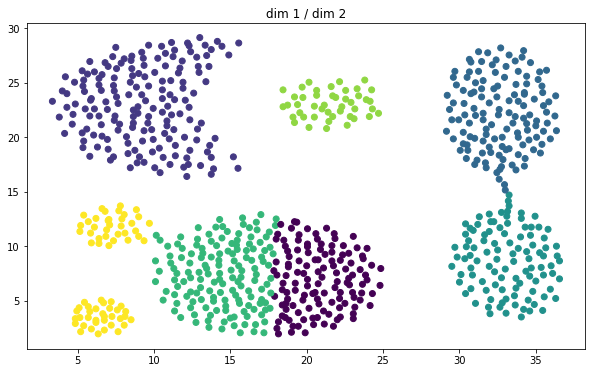

In [70]:
# Generamos el modelo.
model = GaussianMixture(n_components=intrinsic_clusters, max_iter=1000).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)

# Guardamos la métricas.
intrinsic_metrics['EM'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

"""  #    
Este algoritmo tiene una gran variabilidad, resultando óptimo en ocasiones y alejándose de ese resultado en otras.

"""  #

### Comparación algoritmos

In [71]:
display(pd.DataFrame(intrinsic_metrics))

,k-means,Jerárquico,Espectral,Means-Shift,EM
Silhouette,0.480921,0.492535,0.495873,0.498353,0.483790
Calinski Harabasz,1396.503964,1200.171547,1218.664345,1328.760248,1386.276540
Davies Bouldin,0.731845,0.503608,0.509633,0.638932,0.720309


"""  #   
Inicialmente se analizan los algoritmos con un número de clústers distinto para cada uno, sin embargo de cara a la presentación final y conclusiones, escogemos la misma cantidad de grupos para poder comparar y en coherencia con lo que nos dice la visualización del dataset. Este valor será **7**, el cual además iguala bastante los indicadores.

En las predicciones podemos obeservar las siguientes curiosidades. 
> Entre el *Jerárquico aglomerativo* y el *Espectral* podemos observar en el resultado que sólo se diferencia en los puntos de mínima distancia inter-clúster, lo corroboran los indicadores de ambos, que son valores muy similares.

> Los siguientes indicadores similares son *K-Means* y *EM*, principalmente la silueta, y aunque la predicción de clústers no coincide si que se observa que la separación entre muestras y clústers vecinos será parecido, tal y como divide en más de un grupo el conjunto de datos de mayor volumen inferior.

Según el **coeficiente de silueta** tanto con el *Jerárquico* como con el *Means-Shift* obtenemos muestras más separadas de otros clústers vecinos. Pero los valores en el resto de algoritmos son bastante parecidos, y por tanto no es una característica claramente diferenciadora.

Sin embargo, el indicador **Calinski-Harabasz** que relaciona la cohesión y separación de la siguiente forma: $\frac{𝑆𝑆𝐵/(𝑘−1)}
{𝑆𝑆𝑊/(𝑛−𝑘)}$, nos da como mejor resultado de clasificación el obtenido con el algoritmo *K-Means*, seguido del *EM*, esto tiene sentido ya que CH tiende a preferir soluciones de agrupación con agrupaciones que consisten en aproximadamente el mismo número de objetos.

Finalmente el índice **Davies Bouldin**, señala tanto al *Jerárquico* como al *Espectral* como los mejores agrupamientos, esto es debido a que se mide la proporción entre la suma de la dispersión dentro del clúster a la separación entre clústers, y por tanto apremia a resultados de agrupamiento en los que no tienen por qué ser similares los grupos entre si. Esto coincide con lo que nos dice nuestra intuición observando el conjunto de datos. 

"""  #

# Conclusión
Veamos los resultados de uno y otro análisis:

In [72]:
def simplificar_extrinsic():
    e_m = []
    for key in extrinsic_metrics:
        k = {}
        for metrica in extrinsic_metrics[key]:
            if metrica in ['Silhouette','Calinski-Harabasz','Davies-Bouldin']:
                k[metrica] = extrinsic_metrics[key][metrica]
        e_m.append(k)
    e_m_df = pd.DataFrame(e_m).transpose()
    e_m_df.columns = ['k-means','Jerárquico','DBSCAN','Means-Shift','Espectral']
    col_list = list(e_m_df)
    col_list[2], col_list[4] = col_list[4], col_list[2]
    e_m_df.columns = col_list
    return e_m_df

print("Resultados del dataset intrínseco:")
display(pd.DataFrame(intrinsic_metrics))
print("Resultados del dataset extrínseco:")
display(simplificar_extrinsic())

Resultados del dataset intrínseco:


,k-means,Jerárquico,Espectral,Means-Shift,EM
Silhouette,0.480921,0.492535,0.495873,0.498353,0.483790
Calinski Harabasz,1396.503964,1200.171547,1218.664345,1328.760248,1386.276540
Davies Bouldin,0.731845,0.503608,0.509633,0.638932,0.720309


Resultados del dataset extrínseco:


,k-means,Jerárquico,Espectral,Means-Shift,DBSCAN
Silhouette,0.642260,0.633366,0.574677,0.632893,0.372962
Calinski-Harabasz,1692.562129,1653.401714,663.363928,1611.732052,1282.369423
Davies-Bouldin,0.482058,0.504900,1.549794,0.484956,0.929816


""" #    
Se aprecia una diferencia sustancial entre los resultados según si se conoce o no el valor de la clase, muy homogéneos en caso de Silhouette y con una sola excepción (el Espectral) para la métrica de Calinski Harabasz.

Sin embargo, la métrica Davis-Bouldin parece bastante independiente del hecho de que el dataset sea intrínseco o extrínseco.

"""  #